# SageMaker Linear Learner Sample

## Background

Company (3D Technologies) has a fleet of devices transmitting daily aggregated telemetry attributes.

Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. 

This approach promises cost savings over routine or time-based preventive maintenance, because tasks are
performed only when warranted.

## Scope

This work sample is tasked with building a predictive model using machine learning to predict the probability of a device failure. The goal is to to minimize both false positives and false negatives. 

The column we are attempting to predict is called failure, which has a binary value 0 for non-failure and 1 for failure.


## Load the data from S3

In [1]:
# Load dependencies
import boto3, io, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import preprocessing
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer, json_deserializer
import warnings
from sklearn.exceptions import DataConversionWarning

In [2]:
# Initiate SageMaker session
s3_bucket = 'sagemaker-bryfreem'
prefix = 'bryfreem-work-sample'
session = sagemaker.Session()
role = get_execution_role()

In [3]:
# Read CSV Data into Pandas
def read_failure_data(bucket, data_key):
    data_location = get_bucket_uri(bucket, data_key)
    data = pd.read_csv(data_location, encoding = "ISO-8859-1")
    # Convert date column into a datetime datatype
    data['date'] = pd.to_datetime(data['date'])
    return data

# Save CSV data to S3
def save_failure_data(data, bucket, data_key):
    file_name = data_key + ".csv" 
    data.to_csv(file_name)
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(file_name, bucket, data_key)
    
# Get bucket URI
def get_bucket_uri(bucket, data_key):
    return 's3://{}/{}'.format(bucket, data_key)

# Normalize the data
def scale_column(d, c):
    # Supress data conversion warnings
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    x_values = d[c].values
    minmax_scaler = preprocessing.MinMaxScaler()
    x_scaled = minmax_scaler.fit_transform(x_values.reshape(-1, 1))
    result = pd.DataFrame(x_scaled)
    return result

# Set Barplot Labels
def set_barplot_lables(ax):
    ax.set_xlabel("Failure State")
    ax.set_ylabel("Scaled Value")
    return ax

# Split data into train and test sets
def split_data(d):
    mask = np.random.rand(len(d)) < 0.7
    train_set = train = d[mask]
    test_set = d[~mask]
    return train_set, test_set

# Convert the data to numpy arrays
def convert_data(s):
    vectors = np.array(train_set).astype('float32')
    vectors = np.delete(vectors, 0, 1)
    labels = np.array(train_set['failure']).astype('float32')
    return vectors, labels

# Upload the training data to s3
def upload_training_data(b,key='recordio-failure-data'):
    boto3.resource('s3').Bucket(s3_bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(b)
    return 's3://{}/{}/train/{}'.format(s3_bucket, prefix, key)


## Exploring the data

### Overview

Let's load the data and see how many records, unique devices, and failure occurances we have. Let's also see the date range the logs cover.

In [4]:
df = read_failure_data(s3_bucket, 'device_failure.csv')
records = len(df.index)
print ("Row count:", records)
print ("Unique devices:", df['device'].nunique())
failure_count = df.loc[df.failure == 1, 'failure'].count()
print ("Failure occurances:", failure_count)
print ("Log Start Date:", df.date.min())
print ("Log End Date:", df.date.max())
print ("Failures occur in {:.5%}".format(failure_count / records), "of logs." )

Row count: 124494
Unique devices: 1169
Failure occurances: 106
Log Start Date: 2015-01-01 00:00:00
Log End Date: 2015-11-02 00:00:00
Failures occur in 0.08514% of logs.


Using the Pandas head method, let's have a first look at the columns in this dataset.

In [5]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


There is a date, a string device name, a binary failure value, and numeric values for each of the 9 attributes. Let's take a look at the some summary statistics of the numeric attribute fields.

In [6]:
df.describe(include=[np.number])

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


We do not know what measurements or units the values of each attribue represents, but we can see a wide range of positive numbers, and some attribute samples have a very large standard deviation.

Since we are trying to predict the patterns of attribute values that cause failures, lets look at the min/max/mean of the attribute values grouped by failure state.

### Min/Max/Mean by Failure State

In [7]:
df.groupby('failure')[['attribute1', 'attribute2', 'attribute3', 
                      'attribute4', 'attribute5', 'attribute6',
                      'attribute7', 'attribute8', 'attribute9']].mean()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,,,,,,,,,
0,1.223840e+08,156.118725,9.945598,1.696048,14.221613,260174.250587,0.266682,0.266682,12.442462
1,1.271755e+08,4109.433962,3.905660,54.632075,15.462264,258303.481132,30.622642,30.622642,23.084906


In [8]:
df.groupby('failure')[['attribute1', 'attribute2', 'attribute3', 
                      'attribute4', 'attribute5', 'attribute6',
                      'attribute7', 'attribute8', 'attribute9']].min()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,,,,,,,,,
0,0,0,0,0,1,8,0,0,0
1,4527376,0,0,0,3,24,0,0,0


In [9]:
df.groupby('failure')[['attribute1', 'attribute2', 'attribute3', 
                      'attribute4', 'attribute5', 'attribute6',
                      'attribute7', 'attribute8', 'attribute9']].max()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,,,,,,,,,
0,244140480,64968,24929,1666,98,689161,832,832,18701
1,243261216,64784,318,1666,91,574599,832,832,1165


I can see that the mean value of attribute2, attribute4, attribute7, attribute8, and attribute9 are a bit higher under failure conditions. The minimum value of attribute1 is quite a lot higher under failure conditions. Nothing really stands out on the maximum values.

Now, lets try to get a look at the distribution of data under both conditions.

## Attribute Data Distribution

I can see that the attributes have very different scales. I'm going to scale the data using scikit MinMaxScaler.

After scaling, let's see the spread of the data under normal and failure conditions for each attribute.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe461be390>,
      dtype=object)

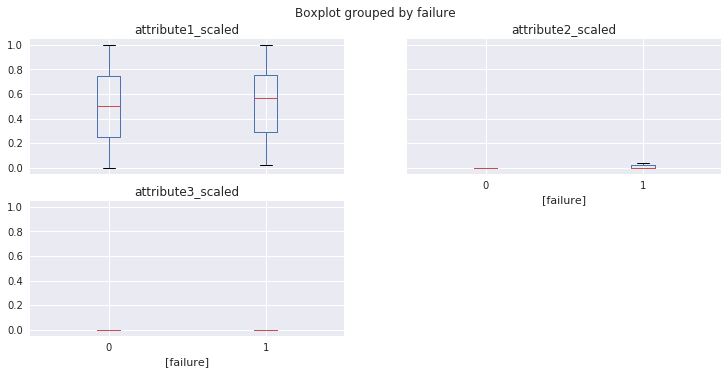

In [10]:
attribute_columns = ["attribute1", "attribute2", "attribute3",
                    "attribute4", "attribute5", "attribute6",
                    "attribute7", "attribute8", "attribute9"]

# Scale the data
for col in attribute_columns:
    column_name = col + "_scaled"
    scaled_data = scale_column(df, col)
    df[column_name] = scaled_data[0].values
    
#Plot first 3 attributes
df.boxplot(column=['attribute1_scaled', 'attribute2_scaled', 'attribute3_scaled'], 
           by=['failure'], 
           figsize= (12,5.5), fontsize = 10.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe448f8780>,
      dtype=object)

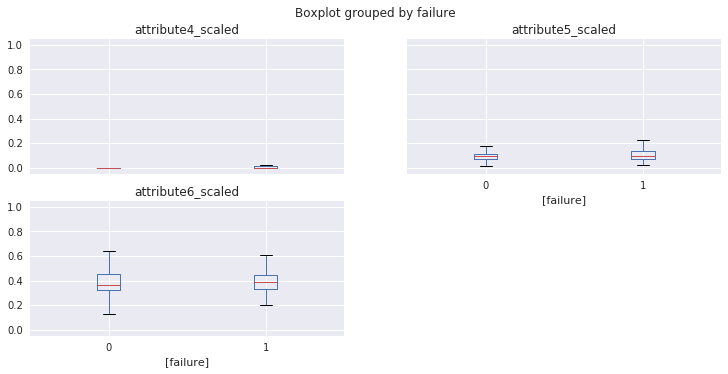

In [11]:
#Plot next 3 attributes
df.boxplot(column=['attribute4_scaled', 'attribute5_scaled', 'attribute6_scaled'], 
           by=['failure'], 
           figsize= (12,5.5), fontsize = 10.0)

All I can really see is that most of the attributes tend toward low values under both conditions. Let's see if we can get a better view of the distribution.

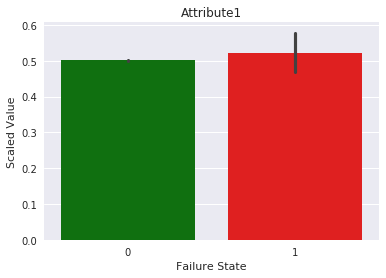

In [12]:
# Set the pallette
sns.set_palette(['green','red'])

# Plot attribute1
plot1 = sns.barplot(x='failure',y='attribute1_scaled',data=df)
plot1.set_title("Attribute1")
set_barplot_lables(plot1)
display(plot1)

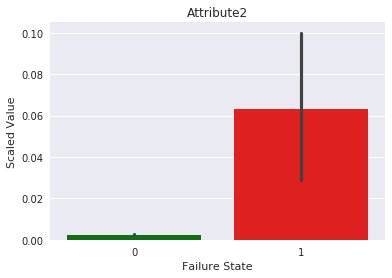

In [13]:
# Plot attribute2
plot2 = sns.barplot(x='failure',y='attribute2_scaled',data=df)
plot2.set_title("Attribute2")
set_barplot_lables(plot2)
display(plot2)

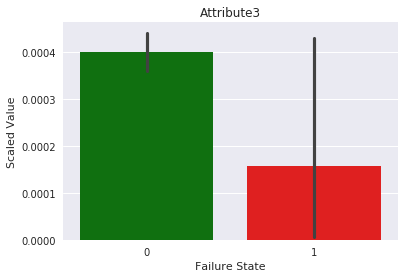

In [14]:
# Plot attribute3
plot3 = sns.barplot(x='failure',y='attribute3_scaled',data=df)
plot3.set_title("Attribute3")
set_barplot_lables(plot3)
display(plot3)

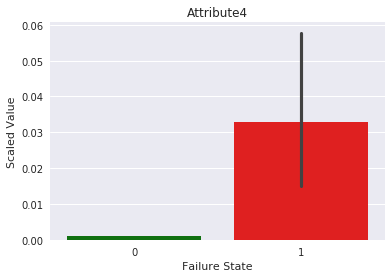

In [15]:
# Plot attribute4
plot4 = sns.barplot(x='failure',y='attribute4_scaled',data=df)
plot4.set_title("Attribute4")
set_barplot_lables(plot4)
display(plot4)

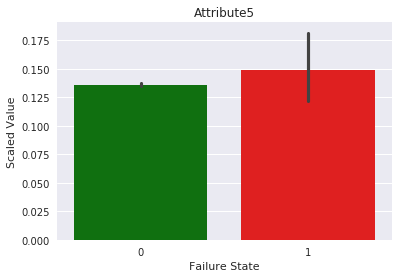

In [16]:
# Plot attribute5
plot5 = sns.barplot(x='failure',y='attribute5_scaled',data=df)
plot5.set_title("Attribute5")
set_barplot_lables(plot5)
display(plot5)

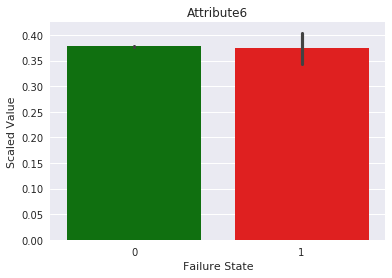

In [17]:
# Plot attribute6
plot6 = sns.barplot(x='failure',y='attribute6_scaled',data=df)
plot6.set_title("Attribute6")
set_barplot_lables(plot6)
display(plot6)

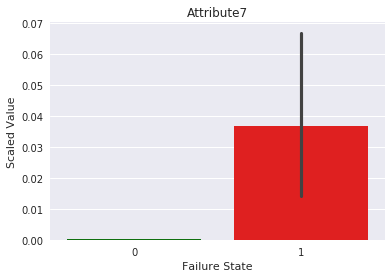

In [18]:
# Plot attribute7
plot7 = sns.barplot(x='failure',y='attribute7_scaled',data=df)
plot7.set_title("Attribute7")
set_barplot_lables(plot7)
display(plot7)

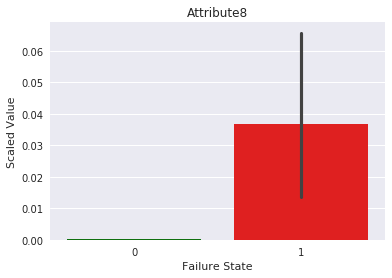

In [19]:
# Plot attribute8
plot8 = sns.barplot(x='failure',y='attribute8_scaled',data=df)
plot8.set_title("Attribute8")
set_barplot_lables(plot8)
display(plot8)

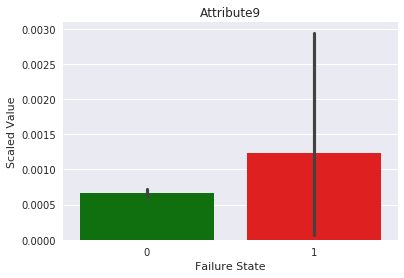

In [20]:
# Plot attribute9
plot9 = sns.barplot(x='failure',y='attribute9_scaled',data=df)
plot9.set_title("Attribute9")
set_barplot_lables(plot9)
display(plot9)

That gives us a little better idea of the data distribution under failure conditions. We can see that attribute2, attribute4, attribute7, attribute8, attribute9 are quite a bit higher under failure conditions.

## Train and Test Data

Now that we have some idea of the data distribution under normal and failure conditions, we can start preparing our training and test data.

Our lables are the failure column, and the dataset needs to contain attribute1_scaled - attribute9_scaled. We will slice those off of the full dataset and shuffle the data to ensure it is in random order.

In [21]:
# Create subset dataframe
df_subset = df[['failure', 'attribute1_scaled', 'attribute2_scaled', 'attribute3_scaled',
               'attribute4_scaled', 'attribute5_scaled', 'attribute6_scaled',
               'attribute7_scaled', 'attribute8_scaled', 'attribute9_scaled']]


# Shuffle the data
df_subset = df_subset.sample(frac=1).reset_index(drop=True)

# Split the data
train_set, test_set = split_data(df_subset)
print("train:{} test:{}".format(train_set.shape, test_set.shape))

# Convert the data
vectors, labels = convert_data(train_set)
print("vectors shape:{} lables shape:{}".format(vectors.shape, labels.shape))

# Create protobuf
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, vectors, labels)
buffer.seek(0)

# Upload training data to A3
s3_train_data = upload_training_data(buffer)
print('training data uploaded to: {}'.format(s3_train_data))

# Set up output location
output_location = 's3://{}/{}/output'.format(s3_bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

train:(87307, 10) test:(37187, 10)
vectors shape:(87307, 9) lables shape:(87307,)
training data uploaded to: s3://sagemaker-bryfreem/bryfreem-work-sample/train/recordio-failure-data
training artifacts will be uploaded to: s3://sagemaker-bryfreem/bryfreem-work-sample/output


## Train the Model

Given that we are trying to predict a binary failure value from a group of numberic features, regression seems a natural fit. I will start with SageMakers Linear Learner algorithm and see what kind of accuracy I can obtain with that.

In [22]:
# Create the estimator
container = get_image_uri(boto3.Session().region_name, 'linear-learner')
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)

# Set the hyper parameters
linear.set_hyperparameters(feature_dim=9,
                           predictor_type='binary_classifier',
                           epochs=5,
                           mini_batch_size=100)

linear.fit({'train': s3_train_data})

2020-04-01 20:59:48 Starting - Starting the training job...
2020-04-01 20:59:49 Starting - Launching requested ML instances......
2020-04-01 21:00:55 Starting - Preparing the instances for training......
2020-04-01 21:01:59 Downloading - Downloading input data...
2020-04-01 21:02:42 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/01/2020 21:02:45 INFO 139768273004352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

[2020-04-01 21:03:34.235] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 24315, "num_examples": 874, "num_bytes": 6984560}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007580206176054846, "sum": 0.007580206176054846, "min": 0.007580206176054846}}, "EndTime": 1585775014.235326, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1585775014.235236}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006983206445118679, "sum": 0.006983206445118679, "min": 0.006983206445118679}}, "EndTime": 1585775014.235413, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1585775014.235391}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0075831179684

[2020-04-01 21:03:58.291] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 24050, "num_examples": 874, "num_bytes": 6984560}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006899027277343189, "sum": 0.006899027277343189, "min": 0.006899027277343189}}, "EndTime": 1585775038.291154, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1585775038.291063}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00666336939131408, "sum": 0.00666336939131408, "min": 0.00666336939131408}}, "EndTime": 1585775038.291252, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1585775038.291231}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0068987019867012

[2020-04-01 21:04:22.590] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 24294, "num_examples": 874, "num_bytes": 6984560}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006705609260965459, "sum": 0.006705609260965459, "min": 0.006705609260965459}}, "EndTime": 1585775062.591087, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1585775062.590997}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006608174191137087, "sum": 0.006608174191137087, "min": 0.006608174191137087}}, "EndTime": 1585775062.591186, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1585775062.591166}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0067053514060

[2020-04-01 21:04:46.720] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 24123, "num_examples": 874, "num_bytes": 6984560}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006626934986753562, "sum": 0.006626934986753562, "min": 0.006626934986753562}}, "EndTime": 1585775086.720523, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1585775086.720443}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006592760900929485, "sum": 0.006592760900929485, "min": 0.006592760900929485}}, "EndTime": 1585775086.720586, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1585775086.720574}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006626013951


2020-04-01 21:05:01 Uploading - Uploading generated training model
2020-04-01 21:05:01 Completed - Training job completed
Training seconds: 182
Billable seconds: 182


In [23]:
# Set up model hosting
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------!

## Validate the Model for Use

Now I will use the test data set to evaluate the performance of the model.

In [24]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
test_vectors = np.array(test_set).astype('float32')


# Test a single result from the test set
result = linear_predictor.predict(test_vectors[100][1:10])

print('Single Sample Result:')
print(result)
print('Actual Label: ', test_vectors[100][0])
print('\n')


Single Sample Result:
{'predictions': [{'score': 0.000736593792680651, 'predicted_label': 0.0}]}
Actual Label:  0.0




In [25]:

batch_size = 100
np.random.shuffle(test_vectors)
arrays = np.array_split(test_vectors[1:], batch_size)
results = []

# Make the preditions
for array in arrays[0]:
    counter = 0
    result_dict = {}
    result = linear_predictor.predict(array[1:10])
    prediction = result['predictions'][0]
    result_dict['score'] = prediction.get('score')
    result_dict['predicted _label'] = prediction.get('predicted_label')
    result_dict['actual_label'] = test_vectors[counter][0]
    results.append(result_dict)

# Summarize the results
correct = 0
false_positive = 0
false_negative = 0

for r in results:
    pred = r.get('predicted _label')
    actual = r['actual_label']
    if pred == actual:
        correct +=1
    elif pred < actual:
        false_negative += 1
    else:
        false_positive += 1
print('Correct: ', correct)
print('False Negative: ', false_negative)
print('False Positive: ', false_positive)

errors = false_positive + false_negative
total = correct + errors
rate = correct/total

print('Percentage Correct: ', rate)
print('\n')

print("Sample:")
for r in results[:10]:
    print(r)

Correct:  372
False Negative:  0
False Positive:  0
Percentage Correct:  1.0


Sample:
{'score': 0.0007307236664928496, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007497306796722114, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007181710680015385, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007279320852831006, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007261269493028522, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007275052485056221, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007394915446639061, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.000706617662217468, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007491861470043659, 'predicted _label': 0.0, 'actual_label': 0.0}
{'score': 0.0007288011838681996, 'predicted _label': 0.0, 'actual_label': 0.0}


### Clean Up

In [26]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)